In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from PIL import Image
import torchvision
from torchvision.utils import make_grid
import os
from tqdm import tqdm
import glob
import pickle
from matplotlib import pyplot as plt
import numpy as np
from torch.optim import Adam
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Create Dataset to hold input and conditional image pair

In [49]:
class ConditionalDataset(Dataset):
    def __init__(self, img_path, img_ext="mpy"):
        self.img_ext = img_ext  # Correct variable name for consistency
        self.image_files = [os.path.join(img_path, f) for f in os.listdir(img_path)]
        self.images = []
        self.inputs = []
        self.conditionals = []
        
        for file in self.image_files:
            filepath = os.path.join(img_path, file)
             # Load image on demand
            with open(filepath, 'rb') as f:
                img_arr = pickle.load(f)  # Assume images are stored as pickled numpy arrays
            
            self.images = img_arr
    
            for idx in range(4, len(self.images)):
                self.inputs.append(self.images[idx])
                self.conditionals.append(self.images[idx - 4])
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        img = self.inputs[index]
        conditional = self.conditionals[index]
        
        # Convert numpy array to tensor
        img_tensor = torchvision.transforms.ToTensor()(img)
        cond_tensor = torchvision.transforms.ToTensor()(conditional)
        
        # Normalize the tensor
        img_tensor = (2 * img_tensor) - 1
        cond_tensor = (2 * cond_tensor) - 1
        return img_tensor, cond_tensor

In [50]:
DATA_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data"

BATCH_SIZE = 64

# create dataset
train_ratio = 0.8
test_ratio = 1 - train_ratio

data = ConditionalDataset(os.path.join(DATA_DIR, "bin_frames"))

train_size = int(train_ratio * (len(data)))
test_size = (len(data)) - train_size

train_data, test_data = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

0


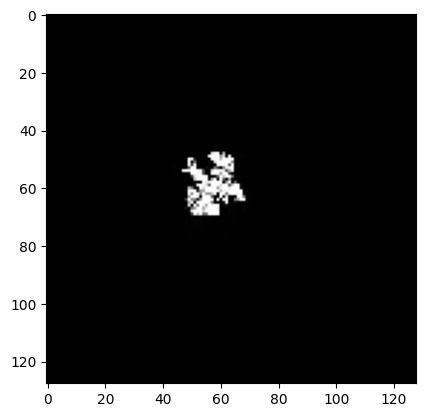

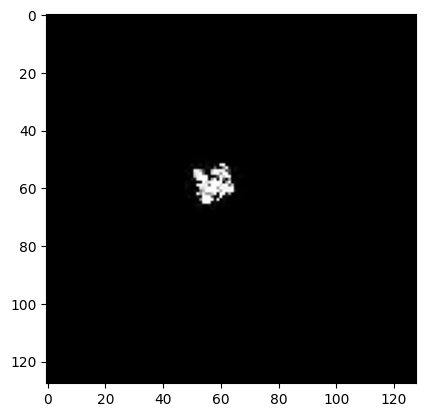

In [55]:
for idx, (x, y) in enumerate(train_loader):
    print(idx)
    plt.imshow(x[0].permute(1, 2, 0), cmap='gray')
    plt.show()
    plt.imshow(y[0].permute(1, 2, 0), cmap='gray')
    plt.show()
    break

### Conditional Denoising Diffusion Model 

#### Noise Scheduler


In [ ]:
class LinearNoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end, device):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0).to(device)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod).to(device)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1. - self.alpha_cum_prod).to(device)
        
    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)
        
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        return sqrt_alpha_cum_prod  * original  + sqrt_one_minus_alpha_cum_prod * noise
    
    
    def sample_prev_timestep(self, xt, noise_pred, t):
        """
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

#### Model component blocks

In [ ]:
def get_time_embedding(time_steps, t_emb_dim):
    factor = 10000 ** ((torch.arange(
        start=0, end=t_emb_dim//2, device=time_steps.device) / (t_emb_dim // 2)
    ))
    t_emb = time_steps[:, None].repeat(1, t_emb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, down_sample, num_heads):
        super().__init__()
        self.down_sample = down_sample
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        
        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_channels)
        )
        
        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        
        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, kernel_size=4,
                                          stride=2, padding=1) if self.down_sample else nn.Identity()
        
    def forward(self, x, t_emb):
        out = x
        # Resnet Block
        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)
        
        # Attention Block
        batch_size, channels, h, w = out.shape
        in_attn = out.reshape(batch_size, channels, h*w)
        in_attn = self.attention_norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        out = out + out_attn
        
        out = self.down_sample_conv(out)
        return out
    
class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim,  num_heads):
        super().__init__()
        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ),
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            )
        ])
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            ),
            nn.Sequential(
                nn.SiLU(), 
                nn.Linear(t_emb_dim, out_channels)
            )
        ])
        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ),
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            )
        ])
        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
        ])
    
    def forward(self, x, t_emb):
        out = x 
        #first resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:,:,None,None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        # attention block
        # batch_size, channels, h, w  = out.shape
        # in_attn = out.reshape(batch_size, channels, h*w)
        # in_attn = self.attention_norm(in_attn)
        # in_attn = in_attn.transpose(1, 2)
        # out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        # out = out + out_attn
        
        # second resnet block
        resnet_input = out
        out = self.resnet_conv_first[1](out)
        out = out + self.t_emb_layers[1](t_emb)[:,:,None,None]
        out = self.resnet_conv_second[1](out)
        out = out + self.residual_input_conv[1](resnet_input)
        
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample, num_heads):
        super().__init__()
        self.up_sample = up_sample
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_channels)
        )
        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        
        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=4, 
                                                    stride=2, padding=1) if self.up_sample else nn.Identity()
        
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        # Resnet Block
        out = x
        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)
        
        # Attention Block
        # batch_size, channels, h, w = out.shape
        # in_attn = out.reshape(batch_size, channels, h * w)
        # in_attn = self.attention_norm(in_attn)
        # in_attn = in_attn.transpose(1, 2)
        # out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        # out = out + out_attn
        
        return out

#### Conditional Unet

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.down_channels = [32, 64, 128, 256]
        self.mid_channels = [256, 256, 128]
        self.t_emb_dim = 128
        self.down_sample = [True, True, False]
        
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(in_channels*2, self.down_channels[0], kernel_size=3, padding=1)  # Adjusted for concatenation
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_heads=4))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim, num_heads=4))
            
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels) - 1)):
            self.ups.append(UpBlock(self.down_channels[i]*2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_heads=4))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, in_channels, kernel_size=3, padding=1)
        
    def forward(self, x, cond, t):
        x = torch.cat([x, cond], dim=1)  # Concatenate input and conditional image
        out = self.conv_in(x)
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)
        
        for mid in self.mids:
            out = mid(out, t_emb)
            
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
        
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        return out

#### Training conditional diffusion

In [74]:
DATA_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data"
RESULT_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results"
CKPT_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts"

NUM_TIMESTEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02

IN_CHANNELS = 1

TASK_NAME = "ddpm_1"
BATCH_SIZE = 32
NUM_EPOCHS = 40
NUM_SAMPLES = 100
NUM_GRID_ROWS = 10
LR = 0.0001
CKPT_NAME = "conditional_ddpm_1.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_conditional_ddpm():
    # create noise scheduler 
    print("Created Noise Scheduler")
    scheduler = LinearNoiseScheduler(num_timesteps=NUM_TIMESTEPS,
                                     beta_start=BETA_START,
                                     beta_end=BETA_END, 
                                     device=device)
    
    # model
    print("Created Model")
    model = Unet(in_channels=IN_CHANNELS).to(device)
    model.train()
    
    # Create output dirs
    if not os.path.exists(os.path.join(RESULT_DIR, TASK_NAME)):
        os.mkdir(os.path.join(RESULT_DIR, TASK_NAME))
    
    # find checkpoint
    if os.path.exists(os.path.join(CKPT_DIR, CKPT_NAME)):
        print("Loading checkpoint found")
        model.load_state_dict(torch.load(os.path.join(CKPT_DIR, CKPT_NAME), map_location=device))
        
    # Training params
    num_epochs = NUM_EPOCHS
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(num_epochs):
        print(f"starting epoch: {epoch}")
        losses = []
        for img_tensor, cond_tensor in train_loader:
            optimizer.zero_grad()
            print("sampling image...")
            img_tensor = img_tensor.float().to(device)
            cond_tensor = cond_tensor.float().to(device)
            
            # sample random noise 
            print("Sampling Noise...")
            noise = torch.randn_like(img_tensor).to(device)
            
            # sample timestep
            print("Sampling Timestep...")
            t = torch.randint(0, NUM_TIMESTEPS, (img_tensor.shape[0],)).to(device)
            
            # Add noise to images according to timestep
            print("Adding Noise to Image...")
            noisy_img = scheduler.add_noise(img_tensor, noise, t)
            print("Predicting Noise...")
            noise_pred = model(noisy_img, cond_tensor, t)
            
            print("Calculating Loss in Predicted Noise...")
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            print("BackProp...")
            loss.backward()
            optimizer.step()
            
        print(f'Finished epoch: {epoch + 1} | Loss: {np.mean(losses)}')
        torch.save(model.state_dict(), os.path.join(CKPT_DIR, CKPT_NAME))
        
    print("Done Training...")

In [ ]:
train_conditional_ddpm()